In [1]:
#using Revise

In [2]:
# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations
using Land
using Land.PhysCon
using Land.WaterVapor
using Land.Leaf
#using IncGammaBeta
output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/Land/test/../output"

In [3]:
# using IncGammaBeta
# psi_l = -0.1e6
# psi_l50 = -1e6;
# ck=3.0;
# b=log(2)*(psi_l/psi_l50)^ck;
# IntWei = inc_gamma_upper_reg(1.0/ck,b) #inc_gamma_upper_reg(1.0/ck,b);
# println("b=",b, " IntWei=",IntWei)
# IntWeibull(-0.3e6,psi_l,psi_l50,ck)

In [4]:
# pore geometry impact
# r = 10e-6
# sigma = 7e-2
# Rv = 461
# T  = 273.15+25
# exp(2*sigma/(r*Rv*1000*T))

In [5]:
# effect of tension in the porous medium
# sigma = 7e-2
# Rv = 461
# T  = 273.15+25

# g = 9.81;
# # r = -2*sigma/psi_l; # effective radius
# # # exp(2*sigma/(r*Rv*1000*T))


# R  = 8.314472
# RH = 80/100
# Vw = 18*(1e-2)^3; # molar volumes of pure water
# # # Psi_a = -R/Vw*T*log(RH)
# # # Psi_a/1e6


# psi_l     = -10e6:0.01e6:-0.01e6
# RH_psi    = zeros(size(psi_l))
# r_psi     = zeros(size(psi_l))
# for i=1:length(psi_l)
#     RH_psi[i]    = 100*exp(psi_l[i]*Vw/(R*T))
#     r_psi[i]     = -2*sigma/psi_l[i]
# end
# plot(psi_l/1e6,RH_psi,xlabel="psi_l (MPa)",ylabel="RH (%)")

# # RH_psi   = 0.1:0.01:1.0
# # psi_l = zeros(size(RH_psi))
# # for i=1:length(psi_l)
# #     psi_l[i] = - R*T/Vw*log(RH_psi[i])  
# # end
# # plot(psi_l/1e6,RH_psi,xlabel="psi_l (MPa)",ylabel="RH (%)")


In [6]:
# plot(psi_l/1e6,r_psi/1e-6,xlabel="psi_l (MPa)",ylabel="r (micrometers)")

In [7]:
# Rd = 287.0 #J K-1 kg-1
# rho_d = 1.2;
# g = 9.81;
# RH = 40/100;
# psi_s = -0.1e6;
# psi_l50 = -2e6;
# ck=3.0;
# dpsi = 0.001*1e6;
# psi_l_vect = (-1*1e6:dpsi:-1e-9);
# y = Ta = zeros(size(psi_l_vect))
# dy_dpsi = zeros(size(psi_l_vect))
# integral_com  = integral_soil_com = zeros(size(psi_l_vect))
# println("psi_50=",psi_l50," ck=",ck, " NO stress=",IntWeibull(psi_s,-0.01e6,psi_l50,ck))
# b0    = log(2)*(psi_s/psi_l50)^ck;
# for i=1:length(psi_l_vect)
#     #y[i] = IntWeibull(psi_s,psi_l_vect[i],psi_l50,ck) # 2^(-(psi_l_vect[i]/l.psi_l50)^l.ck)#
#     b    = log(2)*(psi_l_vect[i]/psi_l50)^ck;
#     y[i] = max(psi_l50/(ck*log(2)^(1.0/ck)) * ( inc_gamma_upper(1.0/ck,b) - inc_gamma_upper(1.0/ck,b0)),0) #+ inc_gamma_upper_reg(1.0/ck,b0);
#     Ta[i]= psi_l_vect[i]/(Rd*log(RH))
#     println("T=",Ta[i])
#     #dy_dpsi[i] = y[i]/(psi_s - psi_l_vect[i])
# end

# #
# #plot!(integral_com)
# #plot(psi_l_vect, integral_com - maximum(integral_soil_com)*ones(size(integral_com)),label="integral")

# plot(psi_l_vect,y,label="analytical int(k(psi) dpsi)",xlabel=" psi_l (Pa)",ylabel=" int k(psi)dpsi (Pa)")
# #plot!(psi_l_vect, -integral_soil_com,label="integral")

# #plot(psi_l_vect, dy_dpsi,label="mean k(psi)")


In [8]:
# psi_gravity = 1000*9.81*10;
# psi_s = -1e6;
# psi_l50 = -2e6;
# ck=3.0;
# dpsi = 0.001*1e6;
# psi_l_vect = (-5*1e6:dpsi:-1e-9);
# y = zeros(size(psi_l_vect))
# dy_dpsi = zeros(size(psi_l_vect))
# integral_com  = integral_soil_com = zeros(size(psi_l_vect))
# b0    = log(2)*(psi_s/psi_l50)^ck;
# for i=1:length(psi_l_vect)
#     b    = log(2)*(psi_l_vect[i]/psi_l50)^ck;
#     y[i] = max(psi_l50/(ck*log(2)^(1.0/ck)) * ( inc_gamma_upper(1.0/ck,b) - inc_gamma_upper(1.0/ck,b0)),0) #+ inc_gamma_upper_reg(1.0/ck,b0);
#     dy_dpsi[i] = y[i]/(psi_s - psi_l_vect[i])
#     if(i>=2)
#         integral_com[i] = integral_com[i-1] + dpsi*2^(-(psi_l_vect[i]/psi_l50)^ck)
#         if(psi_l_vect[i]<psi_s)
#             integral_soil_com[i] = integral_soil_com[i-1] + dpsi*2^(-(psi_l_vect[i]/psi_l50)^ck)
#         else
#             integral_soil_com[i] = integral_soil_com[i-1]
#         end
#     end
# end

# #
# #plot!(integral_com)
# #plot(psi_l_vect, integral_com - maximum(integral_soil_com)*ones(size(integral_com)),label="integral")

# plot(psi_l_vect,y,label="Viscuous drag - analytical int(k(psi) dpsi)",xlabel=" psi_l (Pa)",ylabel=" int k(psi)dpsi (Pa)")
# plot!(psi_l_vect,dy_dpsi*psi_gravity,label="Gravity term",xlabel=" psi_l (Pa)",ylabel=" int k(psi)dpsi (Pa)")

In [9]:
# stab_type_stable = 4;
# z_L = -30.0:0.001:30.0;
# psim_z = zeros(size(z_L));
# psih_z = zeros(size(z_L));
# for i=1:length(z_L) 
#     psim_z[i] = ψ_m(z_L[i],stab_type_stable);
#     psih_z[i] = ψ_h(z_L[i],stab_type_stable);
# end

In [10]:
# plot(z_L,psih_z,label="psi_h")
# plot!(z_L,psim_z,label="psi_m")

In [11]:

# function lorenz!(du,u,p,t)
#  du[1] = 10.0*(u[2]-u[1]);
#  du[2] = u[1]*(28.0-u[3]) - u[2];
#  du[3] = u[1]*u[2] - (8/3)*u[3];
# end
# u0 = [1.0;0.0;0.0];
# tspan = (0.0,100.0);
# prob = ODEProblem(lorenz!,u0,tspan);
# sol = solve(prob);

# plot(sol,vars=(1,2,3))

# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();

#met = meteo();

# initialize some reasonable values
f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; f.H=0;f.LE=0; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=100e-3; l.RWC=80/100;l.psi_l=-1e6;l.psi_l50 = -1e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;
met.stab_type_stable = 2;
l.gstyp = 3;

In [12]:

# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 500; # W/m2 amplitude
Tmean   = 273.15+22;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end
#print(typeof(phase[1]));
#print(typeof(Sdown_t[1]));
#print(Sdown_t);
#clf();
#fig = figure("Diurnal cycle", figsize=(10,5));
# plot(t/3600,Sdown_t)
#plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))))
#    title = "Shortwave Incoming radiation (W/m^2)");#,
#    xlabel = "Hours",
#    ylabel = "S_{down} (W/m^2)")
#plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),
#    title = "Temperature (C)",
#    xlabel = "Hours",
#    ylabel = "Temperature (C)")


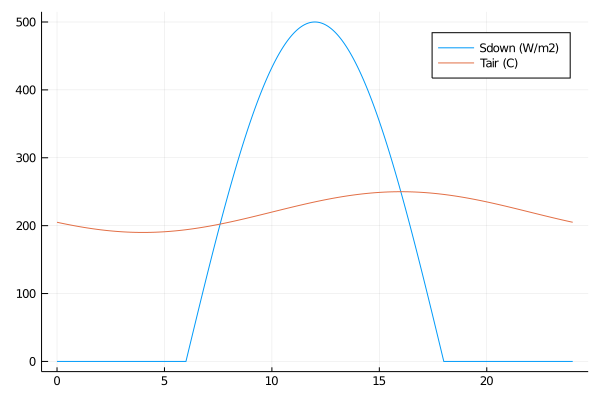

In [13]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [14]:
psi_s      = -1e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    f::fluxes;
    psi_s;
end

In [15]:
# i=700
# met.S_down = Sdown_t[i];
# met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
# met.T_air  = Tair_t[i]+1.;
# l.RH       = 0.8;
# met.e_air  = l.RH*SatVap(Tair_t[i])[1];
# VPD        = SatVap(Tair_t[i])[1] - met.e_air;
# l.VPD      = VPD;
# met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
# met.U      = U;
# met.Ca     = 400.0; #ppm
# f.APAR     = met.PAR;
# f.Cs       = met.Ca;
# println(Sdown_t[i])

In [16]:
# setra!(l, f, met) ;

In [17]:
# LeafPhotosynthesis(f, l, met)


In [18]:
# println("An=",f.An," , ra=",l.ra,", rs=",1.0/(l.gleaf/f.g_m_s_to_mol_m2_s),", rm=",1.0/(l.gm/f.g_m_s_to_mol_m2_s),
# " ci:ca=",l.Ci/met.Ca, ", H=",f.H, " (W/m2), LE=",f.LE, " (W/m2)")

In [19]:
# f.Cs = met.Ca;
# An = 1:0.1:40;
# gs = zeros(size(An));
# for i=1:length(An)
#     f.An = An[i];
#     Medlyn!(f,  l)
#     gs[i]=l.gs;
# end

In [20]:
# plot(An*sqrt(l.VPD)/f.Cs,gs,xlabel="An.RH/Cs [mol.m-2.s-1]",ylabel="gs [mol.m-2.s-1]")

In [21]:
# met.U = 2.0;f.H=400.0;
# met.L=1e6;
# setra!(l,f,met)

In [22]:
# S = 0:1:1000;
# PAR = 45/100*physcon.Wtoμmole_s*S;
# An = zeros(size(S));
# gs = zeros(size(S));
# for i=1:length(S)
#     met.S_down = S[i];
#     f.APAR     = PAR[i];
#     met.PAR    = PAR[i];
#     LeafPhotosynthesis(f, l, met);
#     An[i]=f.An; 
#     gs[i]=l.gs;
# end

In [23]:
# plot(S,An,label="An")

In [24]:
# println(f.g_m_s_to_micromol_m2_s)
# constant = 1e6*met.P_air/(physcon.Rgas*met.T_air);
# println(constant)
# plot(S,1.0 ./ (gs/f.g_m_s_to_micromol_m2_s),label="rs")
# #print(met.RH)
# print(met.P_air)

In [25]:
# S = 250;
# PAR = 45/100*physcon.Wtoμmole_s*S;
# f.APAR     = PAR;
# met.PAR    = PAR;
# T  = 250:1:320
# An = zeros(size(T));
# for i=1:length(T)
#     l.T = T[i];
#     met.T_air = T[i];
#     LeafPhotosynthesis(f, l, met);
#     An[i]=f.An; 
# end

In [26]:
# plot(T,An,label="An")

In [27]:
# small time stepping
dt     = 0.1*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Cc_t   = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
GPP_t  = zeros(size(Sdown_t));
GPP_diffusion_t  = zeros(size(Sdown_t));
LUE_t  = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
rs_t   = zeros(size(Sdown_t));
ra_t   = zeros(size(Sdown_t));

function f_ode!(du,u,p,t) # p are parameters
    du .= LeafEnergyWaterBalance(u[1], u[2], u[3], p.met, p.l, p.f, p.psi_s);
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    # initial conditions
    met.T_air  = Tair_t[1];
    l.T        = met.T_air;
    l.psi_l    = psi_s;
    l.Cc       = 0.6*met.Ca;
    #println("Tair1=",met.T_air," Tleaf1=",l.T," psi_leaf1=",l.psi_l)
        
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        f.APAR     = met.PAR;
        #println("Tair=",met.T_air," Tleaf=",l.T," psi_leaf=",l.psi_l)
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l;l.Cc];
            p    = parameters_ode(l,met,f,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            #du   = zeros(size(u));
            #f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            # Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
            
            
            du   = zeros(size(u));
            f_ode!(du,u,p,t);
            (l.T,l.psi_l,l.Cc) = du*dt+u;
            
#            u0   = [l.T;l.psi_l;l.Cc];
#            prob = ODEProblem(f_ode!,u0,tspan,p);
#            sol  = solve(prob);            
#            # save values
#            met = p.met;
#            f   = p.f;
#            l   = p.l;
#            (l.T,l.psi_l,l.Cc) = sol[1:3,end];
            
            #println("Cc_out=",l.Cc)
            Rn_t[i] = p.f.Rn; H_t[i] = p.f.H; LE_t[i] = p.f.LE; 
            rs_t[i] = 1.0/(p.l.gs/p.f.g_m_s_to_mol_m2_s); 
            ra_t[i] = p.f.ra; 
            GPP_t[i]= p.f.An_biochemistry; 
            GPP_diffusion_t[i]= p.f.An_diffusion; 
            LUE_t[i]= p.f.An_biochemistry/f.APAR; 
            
            #T_old   = l.T;
            #(l.T,l.psi_l) = du*dt+u;
            T_t[i]    = l.T ; #  = T_old; 
            psil_t[i] = l.psi_l;
            Cc_t[i]   = l.Cc;
            
            if(abs(H_t[i])>500)
                println("index ($i) ($j)")
            end
            
            
#             (dumb,l.psi_l) = du*dt+u;
#             T_t[i]  = dumb ; #  = T_old; 

            
        end
    end

#     l.T        = Tair_t[1]; # initialize temperature of the leaf
#     l.psi_l    = psi_s;

#     for i=1:N
#         met.S_down = Sdown_t[i];
#         met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
#         met.T_air  = Tair_t[i];
#         met.ea_air = RH*SatVap(Tair_t[i])[1];
#         u0   = [l.T;l.psi_l];
#         p    = parameters_ode(l,met,psi_s);
#         #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
#         prob = ODEProblem(f_ode!,u0,tspan,p);
#         sol  = solve(prob);
#         (l.T,l.psi_l) = sol[:,end];
#         T_t[i] = l.T; psil_t[i]=l.psi_l;
#         #print((l.T,l.psi_l) )
#         #dT_dt,dH2Ol_dt = LeafEnergyWaterBalance(met, l, psi_s);
#         #l.T        = l.T + Deltat*dT_dt;
#     end

   
end


In [28]:
# met.L = 1e6;
# setra!(l, f, met) ;
# log((met.zscreen - l.d)/l.z0m)
# l.height

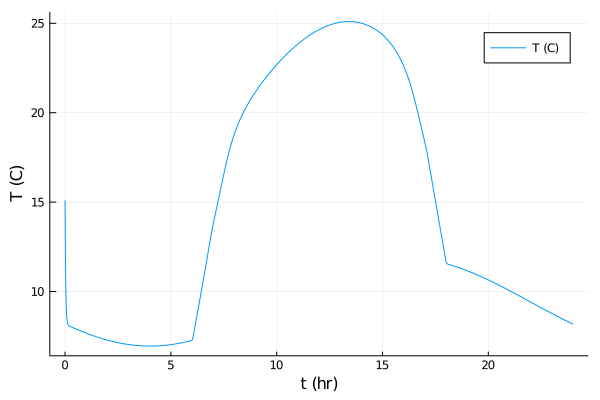

In [29]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)

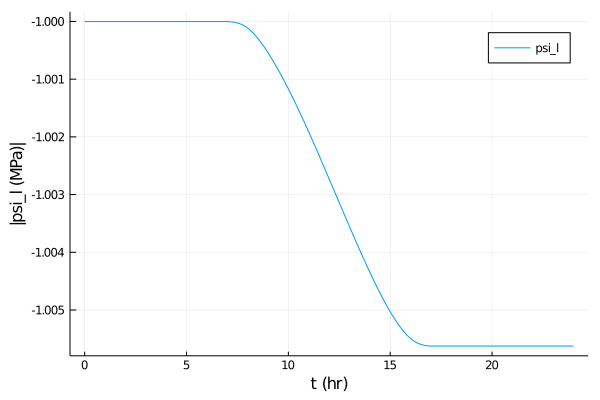

In [30]:
plot(t/3600,psil_t/1e6,xlabel = "t (hr)",ylabel = "|psi_l (MPa)|",label="psi_l",ylim=0:100)

In [31]:
savefig(joinpath(output_dir, "T_psi_diurnal_t.png"))

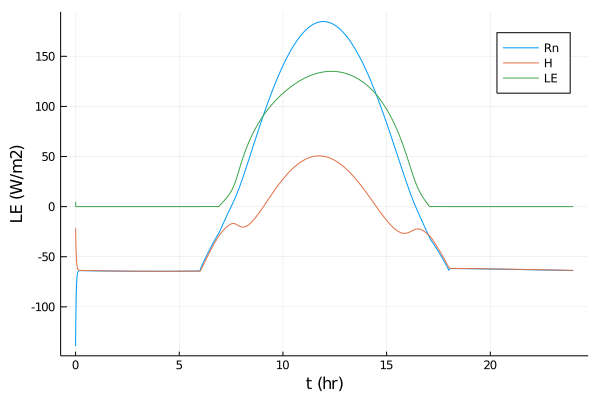

In [32]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn")
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H")
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE")

In [33]:
savefig(joinpath(output_dir, "Fluxes_diurnal_t.png"))

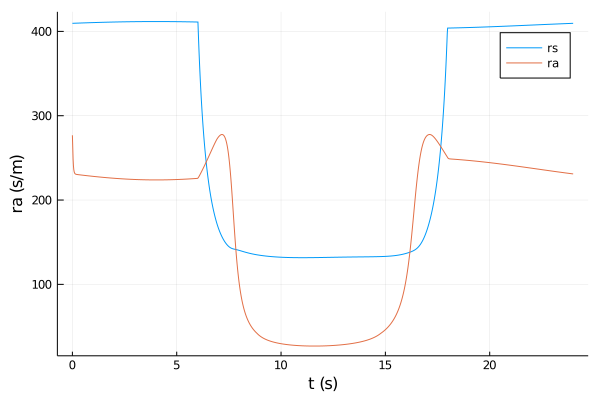

In [34]:
plot(t/3600,  rs_t,xlabel = "t (s)",ylabel = "rs (s/m)",label="rs")
plot!(t/3600, ra_t,xlabel  = "t (s)",ylabel = "ra (s/m)" ,label="ra")

In [35]:
savefig(joinpath(output_dir, "resistances_diurnal_t.png"))

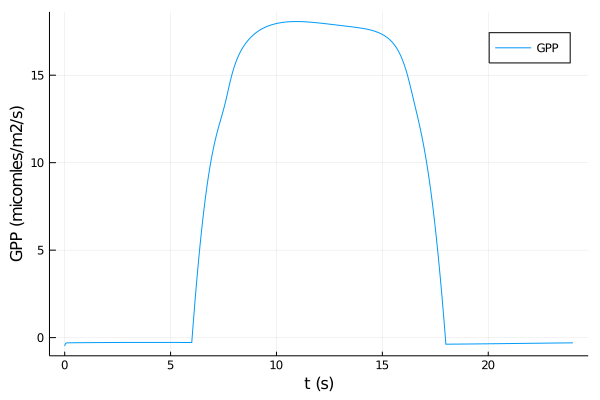

In [36]:
plot(t/3600, GPP_t,xlabel = "t (s)",ylabel = "GPP (micomles/m2/s)",label="GPP",ylim=0:100)

In [37]:
savefig(joinpath(output_dir, "GPP_diurnal_t.png"))

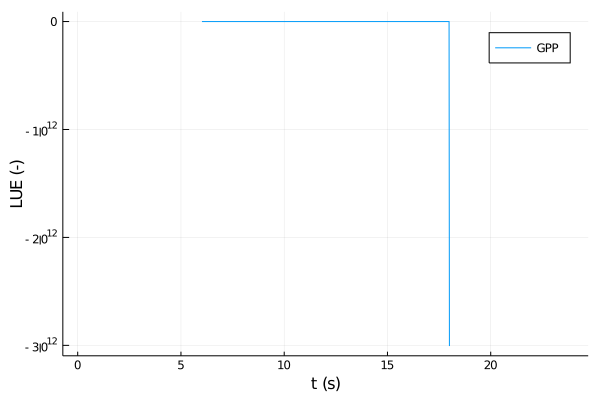

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [38]:
plot(t/3600, LUE_t,xlabel = "t (s)",ylabel = "LUE (-)",label="GPP",ylim=0:100)

In [39]:
savefig(joinpath(output_dir, "LUE_diurnal_t.png"))

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
